In [ ]:
# 0. Define business problem

# PRICING TOOL for Automotive Retail


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


,Age,KM,Weight,HP,MetColor,CC,Doors,Price
0,23.0,46986,1165.0,90,1,2000.0,3,13500.0
1,23.0,72937,1165.0,90,1,2000.0,3,13750.0
2,24.0,41711,1165.0,90,1,2000.0,3,13950.0
3,26.0,48000,1165.0,90,0,2000.0,3,14950.0
4,30.0,38500,1170.0,90,0,2000.0,3,13750.0
...,...,...,...,...,...,...,...,...
1426,78.0,30964,1080.0,110,0,1600.0,3,9950.0
1431,69.0,20544,1025.0,86,1,1300.0,3,7500.0
1432,72.0,19000,1015.0,86,0,1300.0,3,10845.0
1433,71.0,17016,1015.0,86,0,1300.0,3,8500.0


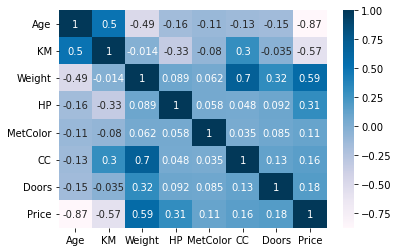

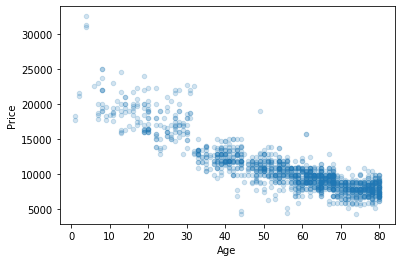

In [ ]:
# 1. Load required libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import pickle
!pip install tensorflow
!pip install keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from google.colab import files
!pip install scikeras[tensorflow]
import scikeras
from scikeras.wrappers import KerasRegressor
from google.colab import drive 

# 2. Collect and prepare data

# Load the data 

drive.mount('/content/drive') # mount Google Drive
CarPricesDataNumeric=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/CarPricesData.pkl') # read the numeric car prices data

# Review data
np.set_printoptions(suppress=True) # remove the scientific notation from numpy arrays
sns.heatmap(CarPricesDataNumeric.corr(), annot= True, cmap='PuBu')
CarPricesDataNumeric.plot(kind='scatter', x='Age', y='Price', alpha=0.2)
CarPricesDataNumeric.head()

# Clean data: 
# a) 
CarPricesDataNumeric= CarPricesDataNumeric.dropna(axis=0, how='any', thresh=None, subset=['Price'], inplace=False) # missing values 
CarPricesDataNumeric['Price']=np.where(CarPricesDataNumeric['Price']<0,CarPricesDataNumeric['Price'].mean(),CarPricesDataNumeric['Price']) # incorect values 
# b)
CarPricesDataNumeric= CarPricesDataNumeric.drop_duplicates(['KM']) # duplicates

CarPricesDataNumeric


In [ ]:
# 3. Define model variables

# Define response variable
Y=CarPricesDataNumeric['Price'].values

# Define predictor variables
Predictors=['Age', 'KM', 'Weight', 'HP', 'MetColor', 'Doors']
X=CarPricesDataNumeric[Predictors].values


In [ ]:
# 4. Define baseline ML model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3) # split the data into training and testing sets

linreg = LinearRegression() #instantiate a new LR model
linreg.fit(X_train, Y_train) 
Y_lr = linreg.predict(X_test) 

In [ ]:
# 5. Interpret baseline ML model

# Evaluate the null model
average_price = CarPricesDataNumeric['Price'].mean()
average_price
num_rows = CarPricesDataNumeric.shape[0]
num_rows
null_model_predictions = [average_price]*num_rows
null_model_predictions
print('nullRMSE is', np.sqrt(metrics.mean_squared_error(Y, null_model_predictions)))

# Evaluate baseline ML model
print('lrRMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_lr))) # RMSE

# Print linear model parameters
print('LR intercept is',linreg.intercept_) # our linear Beta_0
result = zip(Predictors, linreg.coef_) # pair the feature names with the LR coefficients
resultSet = set(result)
print('LR coefficients are', resultSet)

nullRMSE is 3604.4496809783222
lrRMSE is 1316.0733876941486
LR intercept is -9771.495710797126
LR coefficients are {('HP', 29.290407799837983), ('MetColor', 26.137832749546096), ('Weight', 24.04634821999138), ('Doors', -90.0732200544312), ('KM', -0.02383668674544516), ('Age', -111.24697681724945)}


In [ ]:
# 6. Optimize ML model

# Standardization of data 

TargetVariable=['Price']
Y=CarPricesDataNumeric[TargetVariable].values
TargetVarScaler=StandardScaler()
# Storing the fit object for later reference
TargetVarScalerFit=TargetVarScaler.fit(Y)
# Generating the standardized values of y
Y=TargetVarScalerFit.transform(Y)

Predictors=['Age', 'KM', 'Weight', 'HP', 'MetColor', 'CC', 'Doors']
X=CarPricesDataNumeric[Predictors].values
PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)
X=PredictorScalerFit.transform(X) 

In [ ]:
# Hyperparameter tuning

# Listing all the parameters to try
Parameter_Trials={'batch_size':[10, 20, 40, 80],
                      'epochs':[10, 20, 40, 80],
                  'optimizer': ['RMSprop', 'Adam']
                 }

# Function to generate Deep ANN model 
def make_regression_ann():
    model = Sequential()
    model.add(Dense(units=5, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error')
    return model

# Creating the regression ANN model
RegModel=KerasRegressor(make_regression_ann, verbose=0)

grid_search=GridSearchCV(estimator=RegModel, # create the Grid search space
                        param_grid=Parameter_Trials, 
                         scoring='neg_mean_absolute_percentage_error', 
                        cv=2)

grid_search.fit(X,Y) # run Grid Search on feature filtered data

print('### Printing Best parameters ###')
grid_search.best_params_

### Printing Best parameters ###


{'batch_size': 10, 'epochs': 20, 'optimizer': 'RMSprop'}

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
RegModelBest=KerasRegressor(make_regression_ann, optimizer='RMSprop', verbose=0)
# Fitting the ANN to the Training set
RegModelBest.fit(X_train, Y_train ,batch_size = 10, epochs = 20, verbose=1)
# Generating Predictions on testing data
Predictions=RegModelBest.predict(X_test)


# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(Y_test)
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

# Store results in a dataframe

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Price']=y_test_orig
TestingData['PredictedPrice']=Predictions

APE=100*(abs(TestingData['Price']-TestingData['PredictedPrice'])/TestingData['Price']) # computing the absolute percent error
TestingData['APE']=APE
TestingData['PredictedPrice (LR)']=Y_lr

print('The Accuracy of ANN model is:', 100-np.mean(APE))
print('The RMSE of ANN model is:', np.sqrt(metrics.mean_squared_error(y_test_orig, Predictions)))

TestingData

Epoch 1/20
89/89 [==============================] - 1s 2ms/step - loss: 1.0013
Epoch 2/20
89/89 [==============================] - 0s 2ms/step - loss: 0.9229
Epoch 3/20
89/89 [==============================] - 0s 2ms/step - loss: 0.7168
Epoch 4/20
89/89 [==============================] - 0s 1ms/step - loss: 0.4335
Epoch 5/20
89/89 [==============================] - 0s 2ms/step - loss: 0.2185
Epoch 6/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 7/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1342
Epoch 8/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1304
Epoch 9/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1277
Epoch 10/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1264
Epoch 11/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1247
Epoch 12/20
89/89 [==============================] - 0s 2ms/step - loss: 0.1238
Epoch 13/20
89/89 [==============================

,Age,KM,Weight,HP,MetColor,CC,Doors,Price,PredictedPrice,APE,PredictedPrice (LR)
0,70.0,57829.0,1050.0,110.0,0.0,1600.0,3.0,9750.0,8803.744141,9.705188,11495.564108
1,65.0,51000.0,1015.0,86.0,1.0,1300.0,3.0,8950.0,8938.769531,0.125480,17242.602391
2,51.0,34882.0,1075.0,110.0,1.0,1600.0,5.0,12250.0,12425.537109,1.432956,10993.204479
3,40.0,17051.0,1060.0,97.0,0.0,1400.0,5.0,11950.0,12970.625000,8.540795,13008.862242
4,49.0,80090.0,1030.0,97.0,1.0,1400.0,3.0,10750.0,9627.251953,10.444168,10756.656931
...,...,...,...,...,...,...,...,...,...,...,...
374,49.0,68565.0,1030.0,110.0,1.0,1600.0,4.0,8750.0,10407.778320,18.946038,10913.736558
375,32.0,61000.0,1170.0,90.0,0.0,2000.0,3.0,12950.0,15535.183594,19.962808,9588.040196
376,13.0,18000.0,1125.0,71.0,0.0,1400.0,3.0,18500.0,16859.363281,8.868307,12743.726766
377,65.0,55061.0,1070.0,110.0,1.0,1600.0,5.0,9950.0,9575.549805,3.763319,9464.121514


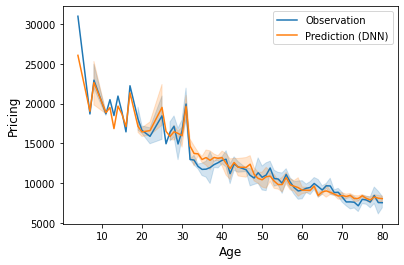

In [ ]:
# 7. Visualize results 
sns.lineplot(data=TestingData, x="Age", y="Price").set_xlabel("Age", fontsize = 12)
sns.lineplot(data=TestingData, x="Age", y="PredictedPrice").set_ylabel("Pricing", fontsize = 12)
plt.legend(labels=["Observation","Prediction (DNN)"])

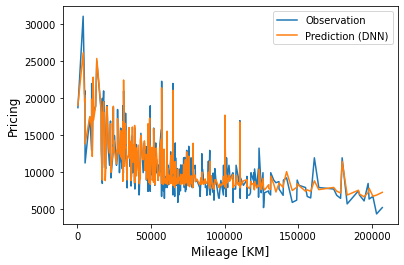

In [10]:
sns.lineplot(data=TestingData, x="KM", y="Price").set_xlabel("Mileage [KM]", fontsize = 12)
sns.lineplot(data=TestingData, x="KM", y="PredictedPrice").set_ylabel("Pricing", fontsize = 12)
plt.legend(labels=["Observation","Prediction (DNN)"])

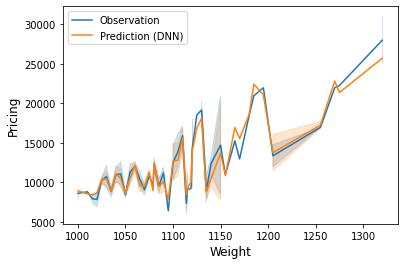

In [11]:
sns.lineplot(data=TestingData, x="Weight", y="Price").set_xlabel("Weight", fontsize = 12)
sns.lineplot(data=TestingData, x="Weight", y="PredictedPrice").set_ylabel("Pricing", fontsize = 12)
plt.legend(labels=["Observation","Prediction (DNN)"])

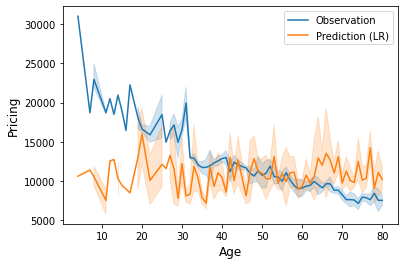

In [ ]:
sns.lineplot(data=TestingData, x="Age", y="Price").set_xlabel("Age", fontsize = 12)
sns.lineplot(data=TestingData, x="Age", y="PredictedPrice (LR)").set_ylabel("Pricing", fontsize = 12)
plt.legend(labels=["Observation","Prediction (LR)"])

In [ ]:
# Feature selection

k_best=[1, 2, 3, 4, 5, 6, 7]

for no_features in k_best: # find best number of features
    fs = SelectKBest(score_func=f_regression, k=no_features) # define filtering method
    Y_trans= Y.ravel()
    X_selected = fs.fit_transform(X, Y_trans) # apply feature selection
    X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y_trans) # split the data into training and testing sets
    model = Sequential() #instantiate a new ANN model
    model.add(Dense(units=5, input_dim= no_features, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train,batch_size = 20, epochs = 10, verbose=0)
    Y_ann= model.predict(X_test)
    print('for k_best =',no_features, 'annError is', np.sqrt(metrics.mean_absolute_percentage_error(Y_test, Y_ann))) 

for k_best = 1 annError is 1.435197558364252
for k_best = 2 annError is 1.2306456096347655
for k_best = 3 annError is 1.0874819678383068
for k_best = 4 annError is 1.1638885661114708
for k_best = 5 annError is 1.4571999763065548
for k_best = 6 annError is 1.2735792502829542
for k_best = 7 annError is 1.2490015657368567


In [12]:
# 8. Save ML model 

# Train again with subset of features (if applicable)

# Deploy as an independent application
filename = 'Car Retail_pricing_tool.sav'
pickle.dump(RegModelBest, open(filename, 'wb')) 

In [13]:
# 9. Use the ML model 
loaded_model = pickle.load(open(filename, 'rb'))
example_car = [[70.0,	57829.0, 1050.0,	110.0,	0.0,	1600.0,	3.0]] 
example_car_standard=PredictorScalerFit.transform(example_car)
print(example_car_standard)
result = loaded_model.predict(example_car_standard)
Prediction=TargetVarScalerFit.inverse_transform(result)
print (Prediction)

[[ 0.78374514 -0.32774494 -0.48292607  0.54776362 -1.46616027  0.13931365
  -1.09040595]]
[[8803.744]]
